<img align="left" width="220px" height="220px" src="https://astra.dk/sites/default/files/DTU%20logo.png" alt="logo"/>
<div>
    <h1 style="text-align: right"> Social Graphs and Interactions (02805)</h1>
    <h2 style="text-align: right"> Final project: True Magic Recipe for Popular Songs</h2>
</div>

# 1 - Motivation

Welcome to the explainer notebook of our social graph and interactions project. Our goal here is to analyse the characteristics (chords, rhythm, lyrics, feeling) of the most recent hits, in order to write your own popular song.

In [ ]:
# Libraries
import billboard
import time
import requests
import json
import pandas as pd
import base64
import statistics
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np
import itertools
import copy
import nltk
import re
import math
import csv
from nltk import word_tokenize
from nltk.corpus import stopwords 
from wordcloud import WordCloud
from PIL import Image

### What are our datasets? Why did we choose this/these particular dataset?

**1.** To achieve our goal, we need to first get our hand on the most recent popular songs. For that we use the [Billboard Hot 100 chart](https://github.com/guoguo12/billboard-charts) and get the best song of each week and select only the one that newly appeared.

In [9]:
# Number of songs we want to keep
number_of_songs = 10000

# Counter for the number of added songs
counter = 0

# Initilization of the list for songs
list_songs = []

# Keepign track of dates
dates = []

# Filling in the list
chart = billboard.ChartData('hot-100', date='2010-11-13')
while counter < number_of_songs:
    #From each song, we keep a list containing the title, the artist
    for song in chart:
        # We add a song only if it has not already been in another chart (this way, we have no duplicates)
        if counter >= number_of_songs:
            break
        elif song.isNew:
            list_songs.append([song.title, song.artist]) 
            counter +=1
    # Here we put a counter to wait a certain amount of time between 2 requests
    # Otherwise, the client send an error because there are too many of them
    time.sleep(10)
    dates.append(chart.previousDate)
    chart = billboard.ChartData('hot-100', chart.previousDate)

    
# Write the content of the list in a text file
f=open("songs.txt",'a')
for song in list_songs:
    f.writelines(song[0] + ";" + song[1])
    f.write('\n') 
f.close()

> The main issue is that at a certain point, our queries to the billboard API couldn't reach it anymore. The solution was to keep track of the last date from which we get songs and write the name of the songs and artists in a file. This way, we could start new queries ate the point we ended and keep the first songs we found.

**2.** The following step is to get the characteristics of those songs. To obtain them, we can begin by using the Spotify API analyze the tempo.
* Load the name and artist of popular songs

In [ ]:
df = pd.read_csv("songs_until_2010-11-13.txt", sep=";", header = None, encoding = "ISO-8859-1")
df.columns = ['Songs', 'Artist']

* Authenticate on Spotify API

In [5]:
userid="userid"
secret="secret"
encodedUser = base64.b64encode(f"{userid}:{secret}".encode("utf-8"))
encodedUser = str(encodedUser, "utf-8")

In [6]:
baseurl = "https://api.spotify.com/v1/"
authReq = "https://accounts.spotify.com/api/token"

headers = {
    'Content-Type': 'application/x-www-form-urlencoded',
    "Authorization": f"Basic {encodedUser}"
}

data={"grant_type": "client_credentials"}

response = requests.post(authReq, headers=headers, data=data)
token = response.json()["access_token"]

headers = {
    "Authorization": f"Bearer {token}"
}

* Look for tempo feature

In [7]:
# Create the list of songs to look for
songs = list(df['Songs'].values)

# We also use the names of the artists because some titles already exist under the same name but by another artist
# Create the list of artists to look for
artists = list(df['Artist'].values)

# Create a list fo both songs and artists to search for
# As the word "featuring" doesn't match anything in spotify, we remove it
toSearch = [songs[i] + " " + artists[i].replace('Featuring', '') for i in range(len(songs))]

# Create a empty list to contain tempos
tempos = []

* We realized that we could not find some titles on the API. We have chosen to place them in an appendix list to count them.

In [8]:
not_found = []

for field in toSearch:
 
    # Get music ID
    search=field
    req = baseurl+ f"search?q={search}&type=track"
    response = requests.get(req, headers=headers)
    try:
        musicId=response.json()["tracks"]["items"][0]["id"]
    except:
        not_found.append(field)
    # Get audio features
    req = baseurl+ f"audio-features/{musicId}"
    response = requests.get(req, headers=headers)
    response_json = response.json()

    #Get tempo
    tempos.append(response_json['tempo'])

In [12]:
print("Number of unfound songs:", len(not_found))
print('Fraction of songs non found', len(not_found)/len(tempos))

Number of unfound songs: 84
Fraction of songs non found 0.021142713314875407


> Since there are only 84 songs not found, which is less than 0.1% of our dataset, we chose simply not to be interested in their tempo.

* Store the results in a text file

In [17]:
# Write the results in a text document, in order to use them more easily
MyFile = open('tempos.txt','w')

for tempo in tempos:
     MyFile.write(str(tempo))
     MyFile.write('\n')
MyFile.close()

* Analyse the tempos

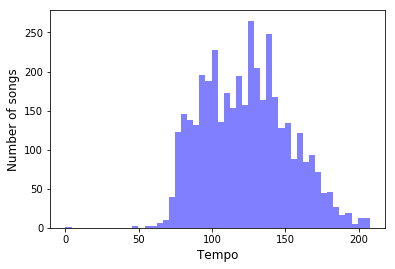

In [24]:
# Plot histogram of the tempo of the songs
num_bins = 50
n, bins, patches = plt.hist(tempos, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Tempo', fontsize=12)
plt.ylabel('Number of songs', fontsize=12)
plt.show()

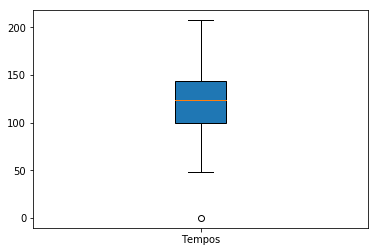

In [27]:
# Plot Boxplot of the repartition of data
plt.boxplot(tempos,patch_artist=True,labels=['Tempos'])
plt.show()

> We only have one outlier. This shows that our data is all distributed in the same range of tempo values. 

> The second and third quartiles concentrate the majority of the values, while the scales of the first and fourth are more extensive. We therefore observe a range of tempo that often returns, centred around the average.

In [28]:
# Compute average of tempos
print("Average tempo: ", statistics.mean(tempos))

Average tempo:  123.39639013340046


**3.** Then we can get the lyrics of each song by calling the Genius API.

In [ ]:
liste = open('songs.txt','r').readlines()
genius = lyricsgenius.Genius("API_key")
songLyrics = []
errors = []

with open('lyrics.txt','a+') as lyrics_file:
    with open('errors.txt','a+') as errors_file:
        for line in liste:
            song_data = line[:-1].split(";")
            #artist = song_data[1].split(' Featuring ')[0].split(' X ')[0].split(' & ')[0]
            song = genius.search_song(song_data[0])#, artist)
            if song == None:
                errors_file.write(line)
                errors.append(line)
            else:
                lyrics_file.write(song.lyrics.replace("\n","/n"))
                lyrics_file.write("\n")

In [55]:
file = open('lyrics.txt','a+')
for lyrics in songLyrics:
    file.write(lyrics.replace("\n","/n"))
    file.write("\n")
file.close()

file = open('errors.txt','a+')
for error in errors:
    file.write(error)
file.close()

Finally, we wanted to have some insight on the chord progression of songs. The only accessible database on this topic was the Hook Theory API. The data is limited to 5000 songs but is still useful for our goal.

* Authentication

In [4]:
baseurl = "https://api.hooktheory.com/v1/"

In [5]:
authReq = baseurl + "users/auth"
body = {
    "username": "username",
    "password": "password"}

response = requests.post(authReq, json=body)

In [6]:
headers = {"Authorization": f"Bearer {response.json()['activkey']}"}

* Get the distribution of chords of songs

In [7]:
req = baseurl+"trends/nodes"
response = requests.get(req, headers = headers)
chords_dist={element["chord_ID"]: element["probability"] for element in response.json()}

* Get the distribution of chords knowing the ONE previous chord

In [9]:
chords = chords_dist.keys()
onechild_chords_dist = {}

k=0
for chord in chords:
    req = baseurl+f"trends/nodes?cp={chord}"
    response = requests.get(req, headers = headers)
    onechild_chords_dist[chord]={element["chord_ID"]: {"weight":element["probability"]} for element in response.json()}
    
    # 10 requests allowed every 10s
    k+=1
    if k==10:
        time.sleep(10)
        k=0

In [11]:
import pickle
# open the file for writing
fileObject = open("onechild_chords",'wb') 
pickle.dump(onechild_chords_dist,fileObject)   
fileObject.close()

# open the file for writing
fileObject = open("chords_dist",'wb') 
pickle.dump(chords_dist,fileObject)   
fileObject.close()

### What was your goal for the end user's experience?

Our main goal is to analyse the characteristics (Chord, rhythm, lyrics, feeling) of the most recent hits, in order to write your own popular song. So the user will get some insight on the songs they hear everywhere on the radio.

# 2 - Basic stats

### **Our choices in data cleaning and preprocessing**

In general, the data we got from the APIs were clean enough. The most meaningful cleanings were made when reusing the Billboard chart dataset to get more informations about the songs:
* To look for featuring in the Spotify dataset, we removed the "featuring" word from the artist name of the Billboard chart.
* Some of the songs could not be found in the Spotify database but represented such a small sample that we decided to drop those songs.

### **Discussion about the dataset stats**

Here are the most important statistics from our datasets:
* Billboard charts: 3972 songs
* Chords progression network (Hooktheory): 213 chords(nodes) linked by 1880 edges
* Lyrics: 8.7 MB of data extracted from genius lyrics, 70,7 MB of data extracted from LyricsFreak

# 3 - Tools, theory and analysis

### **Which network science tools and data analysis strategies we've used, how those network science measures work, and why the tools we've chosen are right for the problem we're solving.**

#### Load data

In [21]:
fileObject = open("onechild_chords",'rb')  
onechild_chords_dist = pickle.load(fileObject)  

fileObject = open("chords_dist",'rb')  
chords_dist = pickle.load(fileObject)  

In [22]:
G=nx.DiGraph(onechild_chords_dist)
nx.set_node_attributes(G, chords_dist, name="proba")

In [23]:
undirected = G.to_undirected()

#### Basic analysis
Let's take a look at some basic attributes of a graph: Number of nodes, number of edges, degree distribution to gain some quick review of the graph.

In [24]:
print(f"There are {G.number_of_nodes()} nodes")

There are 213 nodes


In [25]:
print(f"There are {G.number_of_edges()} edges")

There are 1880 edges


In [26]:
ordered_degrees = sorted(G.degree(weight="weight"), key=lambda x:x[1], reverse=True)
print("Chords with highest degrees:")
print(ordered_degrees[:5])

Chords with highest degrees:
[('6', 7.352), ('4', 6.231), ('1', 5.887999999999999), ('5', 4.992), ('2', 3.035)]


In [27]:
ordered_proba = sorted([(node, float(data.get("proba") or 0)) for node, data in G.nodes(data=True)], 
                       key=lambda x:x[1], 
                       reverse=True)
print("Chords with highest probability of being in a song:")
print(ordered_proba[:5])

Chords with highest probability of being in a song:
[('1', 0.145), ('4', 0.142), ('6', 0.138), ('5', 0.137), ('2', 0.049)]


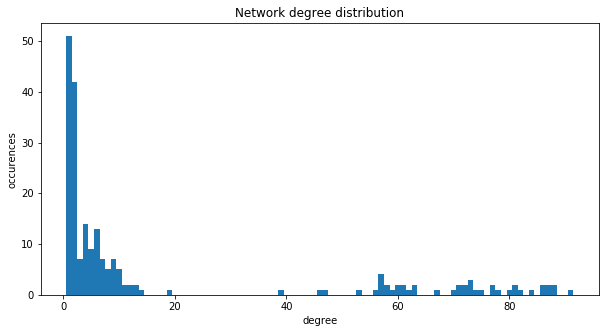

In [28]:
# Degree distribution
degrees = [d for n,d in G.degree]
v = np.arange(np.min(degrees), np.max(degrees)+2)
hist, bin_edges = np.histogram(degrees, bins=v)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(bin_edges[:-1], hist, width = 1)
ax.set_title("Network degree distribution")
ax.set_xlabel("degree")
ax.set_ylabel("occurences")
plt.show()

>We noticed that many chords had a low degree, which meant that they were often played alone or played infrequently (less than 15 times out of 5000 songs). On the other hand, a minority of chords are very present, some of them appearing in more than 90 successions of chords in the songs in the database.\
>There are some privileged chords. Chords with the highest degrees are also those with the highest probability of appearing in a song. These are the chords '1', '4', '6' and '5' which have about **14%** chance of appearing in a song.

#### Most common chords progressions
An important feature that we need for our popular song recipe is the most common chords progressions. Let's try to look for them.

*3 chords progression*
> We want all permutations without the circular permutations. This is equivalent to getting all combinations from the list and for each combination get all the permutation of the combination without the first element added to the first element. Using this method prevent repeated search and save us a lot of time.

In [179]:
# We don't want to stock everything just the top 10 for instance
prog3=[("",0)]*10
count = 0

for comb in itertools.combinations(list(G.nodes()), 3):
    for permut in ((comb[0],)+tup for tup in itertools.permutations(comb[1:])):
        temp=1
        count+=1
        try:
            for i in range(len(permut)):
                temp*=G[permut[i]][permut[(i+1)%len(permut)]]["weight"]
        except:
            temp = 0
        if temp>0 and sum([b<temp for a,b in prog3])>0:
            prog3[np.argmin([b for a,b in prog3])]=(permut, temp)

In [180]:
prog3 = sorted(prog3, key=lambda x:x[1], reverse=True)

In [181]:
prog3

[(('4', '5', '6'), 0.01737216),
 (('1', '5', '4'), 0.014929739999999999),
 (('1', '4', '5'), 0.011059775999999999),
 (('1', '5', '6'), 0.006945120000000001),
 (('1', '6', '4'), 0.0067048),
 (('1', '6', '5'), 0.004262200000000001),
 (('4', '6', '5'), 0.003975360000000001),
 (('4', '5', '3'), 0.0037555199999999996),
 (('1', '3', '4'), 0.0035801319999999998),
 (('4', '5', '2'), 0.00285696)]

*4 chords progression*\
> Here the number of combinations possible is huge, so we will assume that the most central chord is necessarily in the most used chords progression.

In [113]:
top1 = ordered_degrees[0][0]

In [115]:
prog4=[("",0)]*10
count = 0
for comb in itertools.combinations(list(G.nodes()), 3):
    comb = (top1,)+comb
    for permut in ((comb[0],)+tup for tup in itertools.permutations(comb[1:])):
        temp=1
        count+=1
        try:
            for i in range(len(permut)):
                temp*=G[permut[i]][permut[(i+1)%len(permut)]]["weight"]
        except:
            temp = 0
        if temp>0 and sum([b<temp for a,b in prog4])>0:
            prog4[np.argmin([b for a,b in prog4])]=(permut, temp)

        if count%10000000==0:
            print(count//10000000)

In [117]:
prog4 = sorted(prog4, key=lambda x:x[1], reverse=True)

In [118]:
prog4

[(('6', '4', '1', '5'), 0.00439298496),
 (('6', '3', '4', '5'), 0.0014646528000000002),
 (('6', '1', '4', '5'), 0.0014445849600000001),
 (('6', '4', '5', '1'), 0.0014098176),
 (('6', '5', '4', '1'), 0.001196749),
 (('6', '5', '6', '4'), 0.0011697254400000001),
 (('6', '4', '6', '5'), 0.0011697254400000001),
 (('6', '4', '1', '56'), 0.0008850336),
 (('6', '3', '6', '5'), 0.0008319168000000001),
 (('6', '5', '6', '3'), 0.0008319168000000001)]

> We find the infamous "4 magical chords" that is used everywhere (VI, IV, I, V)

#### Centrality
Analysing the centrality could give us a measure of how well a chord is used in current musical progressions. We analysed the centrality using both degree and eigenvector.

*Prepare positions of nodes for the graph visualization*

In [242]:
from fa2 import ForceAtlas2
import matplotlib.patches as mpatches

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,
    
                        # Log
                        verbose=False)

In [243]:
positions = forceatlas2.forceatlas2_networkx_layout(undirected, pos=None, iterations=1000)

*Degree centrality*

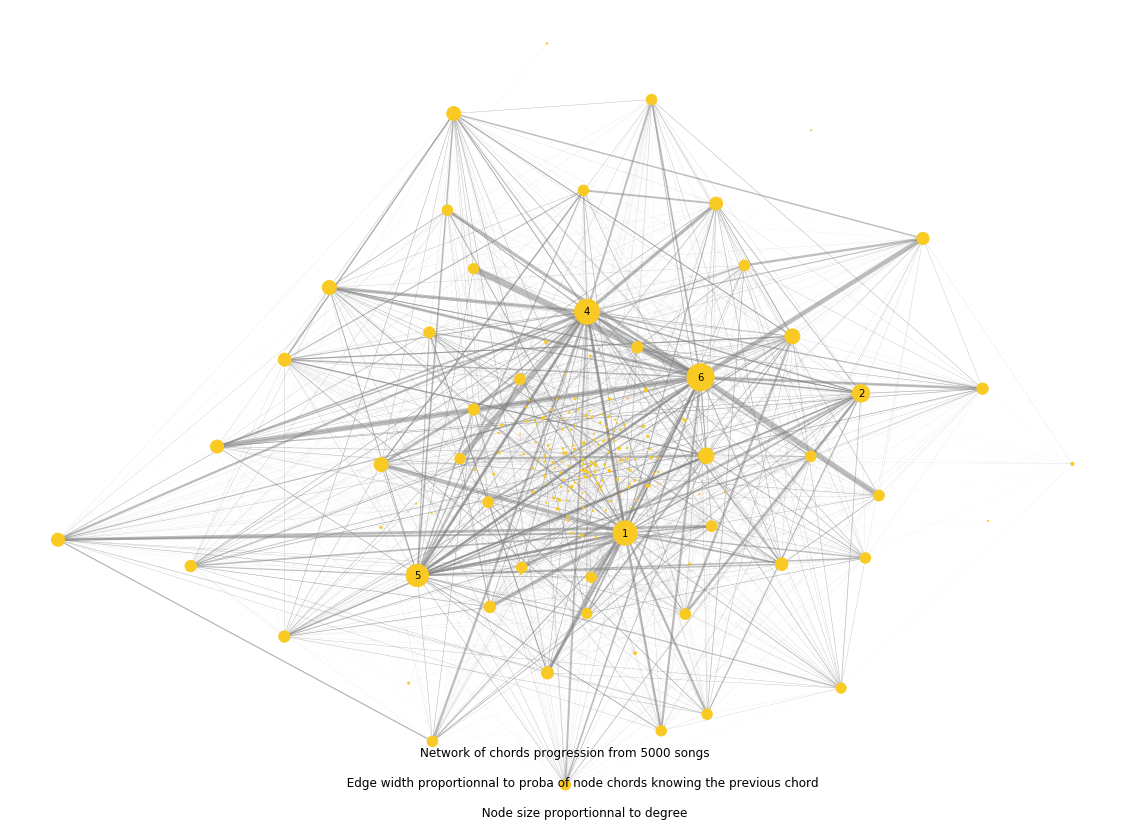

In [191]:
# node
#node_size=[data.get("proba",0.0001)*5000 for node, data in G.nodes(data=True)]

node_size=[1+value*100 for node, value in G.degree(weight = "weight")]
#node_size=[1+value*1000 for node, value in nx.betweenness_centrality(G).items()]

node_label={}
for node, value in sorted(G.degree(weight="weight"), key=lambda x:x[1], reverse=True)[:5]:
    node_label[node] = node

# width
width_list = [d["weight"]*10 for (u, v, d) in G.edges(data=True)]
  
# draw
plt.figure(figsize=(20,15))

# nodes
nx.draw_networkx_nodes(G, positions, 
                       node_color="#f9ca24", 
                       node_size=node_size,
                       alpha=1)

nx.draw_networkx_labels(G, positions, labels=node_label, font_color="black", font_size=10)

# edges
nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=0.5, width=width_list, arrows=False)

# legend
plt.axis('off')
plt.title("""Network of chords progression from 5000 songs\n 
          Edge width proportionnal to proba of node chords knowing the previous chord \n
          Node size proportionnal to degree""", y=0)

plt.show()

>For the degree centrality, the most central chords are of course the chords with the highest degree we displayed before.

*Eigenvector centrality*

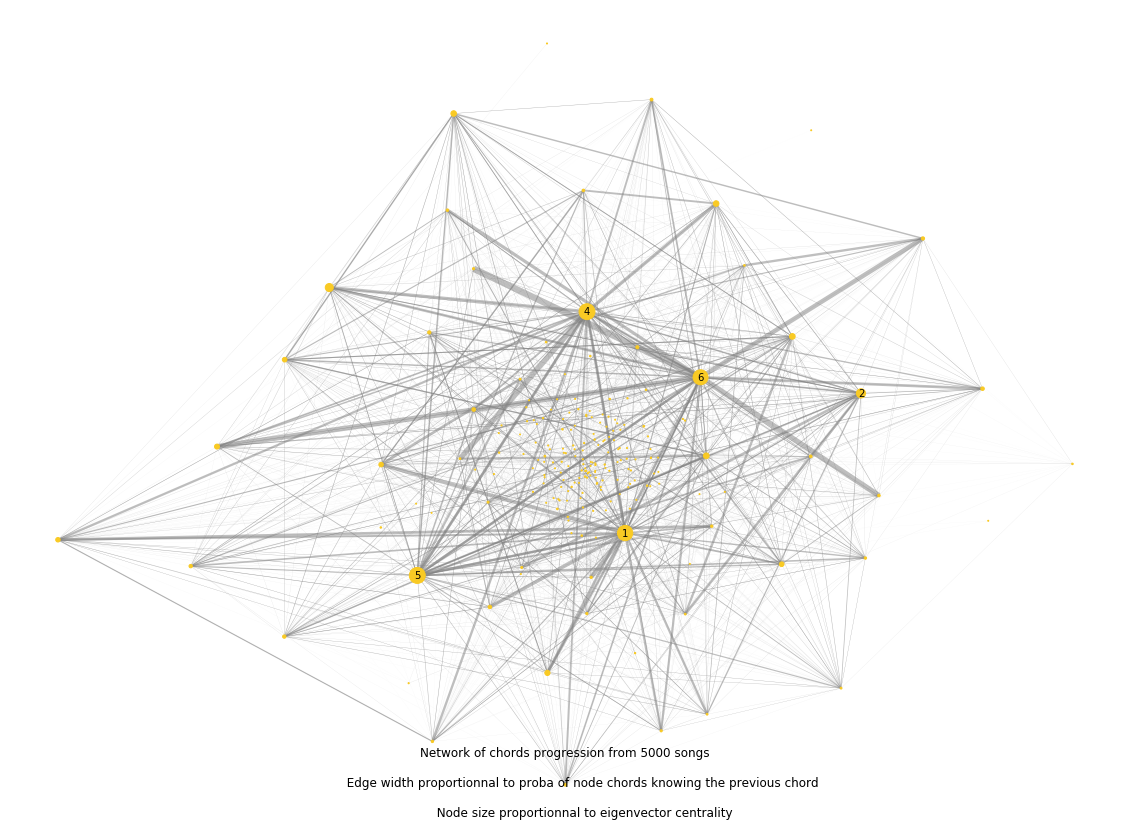

In [192]:
node_size=[1+value*500 for node, value in nx.eigenvector_centrality(G, weight="weight").items()]

node_label={}
for node, value in sorted(nx.eigenvector_centrality(G, weight="weight").items(), key=lambda x:x[1], reverse=True)[:5]:
    node_label[node] = node


# draw
plt.figure(figsize=(20,15))

# nodes
nx.draw_networkx_nodes(G, positions, 
                       node_color="#f9ca24", 
                       node_size=node_size,
                    alpha=1)

# labels
nx.draw_networkx_labels(G, positions, labels=node_label, font_color="black", font_size=10)

# edges
nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=0.5, width=width_list, arrows=False)

# legend
plt.axis('off')
plt.title("""Network of chords progression from 5000 songs\n 
          Edge width proportionnal to proba of node chords knowing the previous chord \n
          Node size proportionnal to eigenvector centrality""", y=0)

plt.show()

>  Using the eigenvector centrality, we found no difference between the most central chords given.

*Discussion*

>  The most central chords found through eigenvector centrality might not have the greatest number of connections, but they are linked to other influential chords. Here, we find the same central chords for both the degree centrality and eigenvector centrality. This means that the most represented chords also seem to be all linked together. So there seems to be a serie of chord progressions that come back often. 

In [126]:
sorted(G.degree(weight="weight"), key=lambda x:x[1], reverse=True)[:5]

[('6', 7.352),
 ('4', 6.231),
 ('1', 5.887999999999999),
 ('5', 4.992),
 ('2', 3.035)]

In [127]:
sorted(nx.eigenvector_centrality(G, weight="weight").items(), key=lambda x:x[1], reverse=True)[:5]

[('5', 0.506631956983384),
 ('4', 0.501929220341171),
 ('1', 0.4644318989773976),
 ('6', 0.447051735482204),
 ('2', 0.16644261123133708)]

#### Community detection
In this part we'll try to find communities in our network through the louvain algorithm

*Compute community*

In [265]:
import community

In [274]:
partition = community.best_partition(undirected, weight="weight")

In [275]:
subNodes = {key:[] for key in set(partition.values())}
for key, value in partition.items():
    subNodes[value].append(key)

M = 0.0
L = G.number_of_edges()

for nodes in subNodes.values():
    subG = G.subgraph(nodes)
    subk = np.average([d for i, d in subG.degree])
    subL = subG.number_of_edges()
    M += subL/L - pow(subk/(2*L),2)
    
print("Modularity:",M)

Modularity: 0.3228611827882789


> The modularity is superior to 0 but is a bit far from 1 so cliques seems to emerge from this network but they are not clearly apparent.

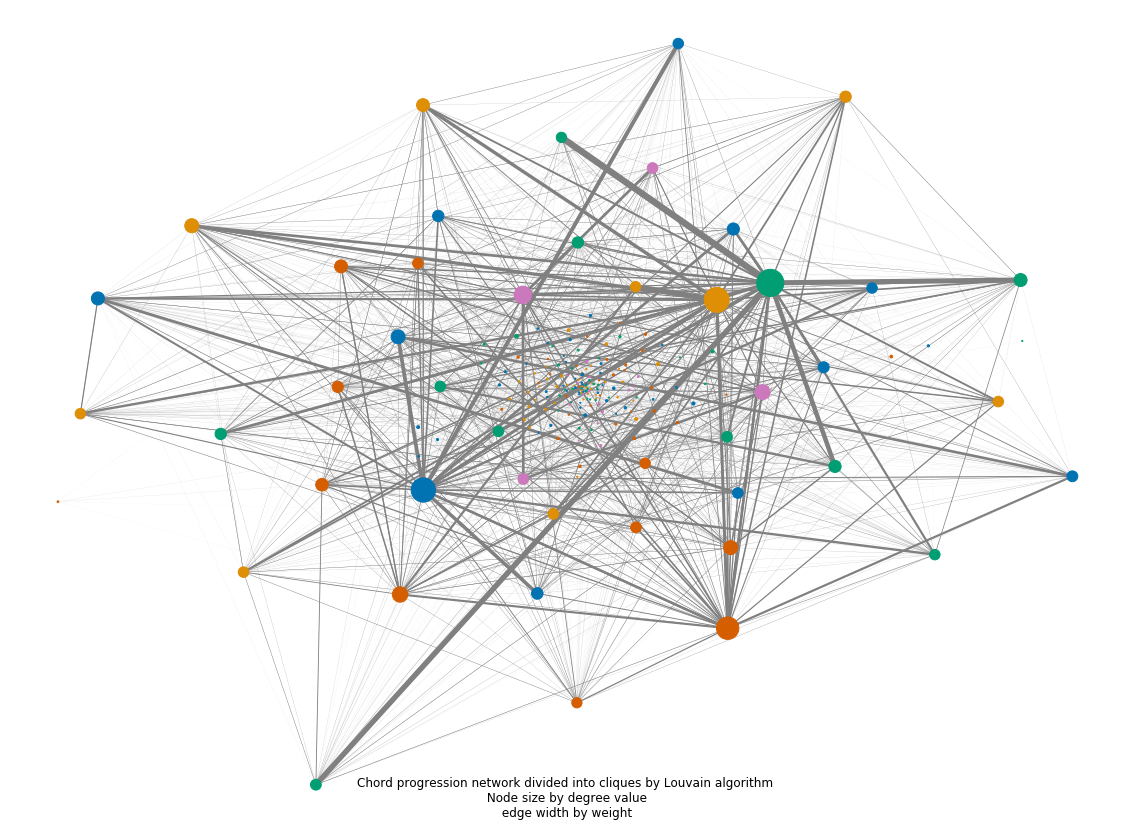

In [276]:
# color

colors = sns.color_palette(palette="colorblind", n_colors=len(subNodes.keys()))
color_map=[]

for name in G.nodes():
    try:
        color_map.append(colors[partition[name]])
    except:
        print(name)

        
node_size=[1+value*100 for node, value in G.degree(weight="weight")]
        
# line width
width_list = [d["weight"]*10 for (u, v, d) in G.edges(data=True)]
  
# draw
plt.figure(figsize=(20,15))

# nodes
nx.draw_networkx_nodes(G, positions, 
                       node_color=color_map, 
                       node_size=node_size,
                       with_labels=False, alpha=1)

# edges
nx.draw_networkx_edges(G, positions, edge_color="grey", alpha=1, width=width_list, arrows=False)

# legend
plt.axis('off')
plt.title("Chord progression network divided into cliques by Louvain algorithm\n Node size by degree value\n edge width by weight", y=0, x=0.5)
plt.show()

*Analysis*
> The graph is not too explicit so let's try to make sense by plotting subgraphs with each community and get their most common chord progression.

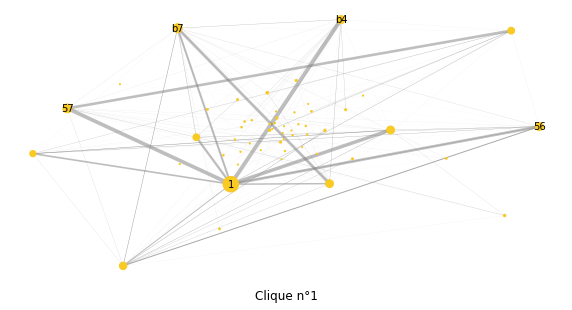

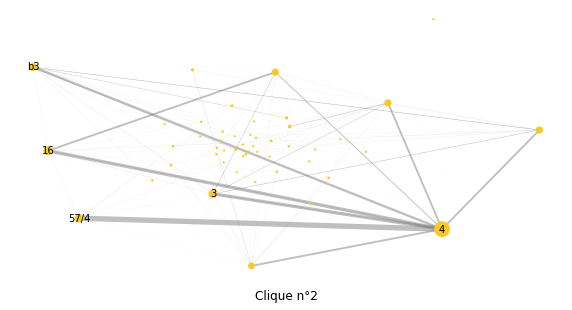

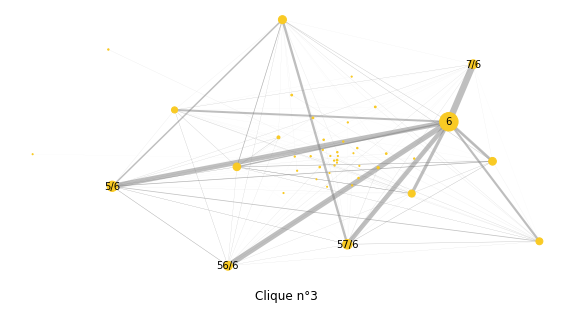

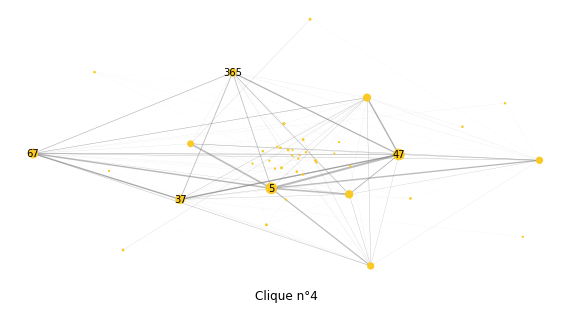

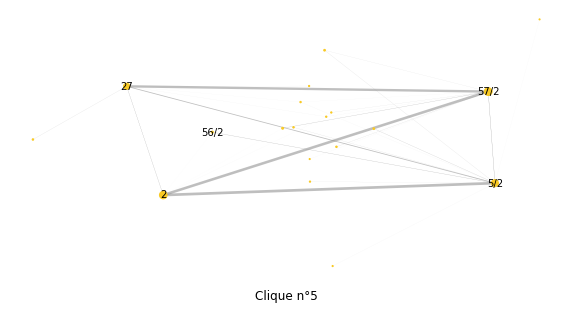

In [277]:
common_chord_by_community = []

for key in subNodes:
    
    # ----------------------- init network -----------------------
    sub_G = G.subgraph(subNodes[key])
    sub_undirected = sub_G.to_undirected()
    
    # ----------------------- draw network -----------------------
    sub_positions = forceatlas2.forceatlas2_networkx_layout(sub_undirected, pos=None, iterations=500)
    
    node_size=[1+value*100 for (node, value) in sub_G.degree(weight = "weight")]
        
    node_label={}
    for (node, value) in sorted(sub_G.degree(weight="weight"), key=lambda x:x[1], reverse=True)[:5]:
        node_label[node] = node
    
    # width
    width_list = [d["weight"]*10 for (u, v, d) in sub_G.edges(data=True)]

    # draw
    plt.figure(figsize=(10,5))

    # nodes
    nx.draw_networkx_nodes(sub_G, sub_positions,
                           node_color="#f9ca24", 
                           node_size=node_size,
                           alpha=1)

    nx.draw_networkx_labels(sub_G, sub_positions, labels=node_label, font_color="black", font_size=10)

    # edges
    nx.draw_networkx_edges(sub_G, sub_positions, edge_color="grey", alpha=0.5, width=width_list, arrows=False)

    # legend
    plt.axis('off')
    plt.title(f"Clique n°{key+1}", y=-0.1)

    plt.show()
    
    # ----------------------- get common chord -----------------------

    top1 = max(sub_G.degree(weight="weight"), key=lambda x:x[1])[0]
    max_prog3=("", 0)
    for comb in itertools.combinations(list(sub_G.nodes()), 2):
        comb = (top1,)+comb
        for permut in ((comb[0],)+tup for tup in itertools.permutations(comb[1:])):
            temp=1
            try:
                for i in range(len(permut)):
                    temp*=sub_G[permut[i]][permut[(i+1)%len(permut)]]["weight"]
            except:
                temp = 0
            if temp>0 and max_prog3[1]<temp:
                max_prog3=(permut, temp)
    
    common_chord_by_community.append(max_prog3)

> From these graphs alone we cannot extract a lot of information. We can see that each major chord is in a different clique. This could just mean that these chords are strongly linked to less frequent one. So each major chord would have a set of uncommon chords that are usually played together.\
\
Let's try to get the most common chord progression by community and look for songs that contain those chords.

In [278]:
common_chord_by_community

[(('1', 'b6', 'b7'), 0.00022624000000000003),
 (('4', '542', '16'), 0.00031657500000000004),
 (('6', '664', '5/6'), 0.0007300799999999999),
 (('5', '67', '47'), 0.00022788),
 (('57/2', '2', '5/2'), 1.7160000000000002e-05)]

In [279]:
# Authentication

baseurl = "https://api.hooktheory.com/v1/"
authReq = baseurl + "users/auth"
body = {
    "username": "CubicOtter",
    "password": "NZCGH9z83CEg!f6"}

response = requests.post(authReq, json=body)
headers = {"Authorization": f"Bearer {response.json()['activkey']}"}

In [280]:
#Get songs corresponding to most popular chord progression by community

common_songs_by_community=[]
for chords in common_chord_by_community:
    req = baseurl+f"trends/songs?cp={','.join(chords[0])}"
    response = requests.get(req, headers = headers)
    if(response.text[0]=="["):
        common_songs_by_community.append([(item["artist"], item["song"]) for item in response.json()])
    else:
        common_songs_by_community.append([])

In [281]:
common_songs_by_community

[[('Yoko Ueno', 'Raspberry Heaven'),
  ('Connan Mockasin', "It's Choade My Dear"),
  ('Nintendo - Asuka Ohta - Ryo Nagamatsu', 'Mario Kart Wii - Luigi Circuit'),
  ('Nickelback', 'Hero'),
  ('Liptick', "I'm A Raver"),
  ('Liptsick', "I'm A Raver"),
  ('Lipstick', "I'm A Raver"),
  ('Game Freak', 'Nacrene City'),
  ('Game Freak', 'Vs Frontier Brain - Sinnoh'),
  ('Sonic Underground', 'Sonic Underground Theme Song'),
  ('Sheryl Crow', 'All I Wanna Do'),
  ('Douglas Firs', 'Shimmer and Glow'),
  ('Tristam', 'Once Again'),
  ('cYsmix', 'Fortune Teller'),
  ('SEGA', 'Sonic Battle - Emerald Town'),
  ('Daughtry', 'Over You')],
 [('Johann Johannson', 'IBM 1401 Processing Unit'),
  ('Procul Harum', 'Fellow Travellers'),
  ('Alan Silvestri', 'Back to the Future Theme'),
  ('Johann Sebastian Bach', 'BWV 894 - Prelude in A minor'),
  ('Nintendo', 'Super Mario Galaxy - Buoy Base Galaxy'),
  ('Nintendo', 'Beach Bowl Galaxy'),
  ('Alan Silvestri', 'The Cosmos Is Yours - Cosmos A SpaceTime Odyssey'),

> Here we can see that the database might be too small to do this kind of analysis. It's a database made by users so some of the songs here is not necessarily interesting for us. Overall the songs are too diverse so it's difficult to make sense to this result. We might have gotten meaningful results if the database was less sparsed and more abundant.

**Lyrics analysis**

> To begin with, we prepare the function that will help us format the lyrics as word tokens, using regular expressions.

In [125]:
#Functions to format the lyrics in the wanted way.
#Exclude punctuation
def supprPunctuation(tokens):
    return([w for w in tokens if w.isalpha()])

#Exclude stop words, lowercase all other words
def supprStopWords(tokens):
    stop_words = set(stopwords.words('english') + stopwords.words('spanish') + ['ooh','yeah','oh','is','to','got','want','hey','let'])
    return([w.lower() for w in tokens if not w.lower() in stop_words])

#Exclude numbers
def supprNumbersAndTitles(txt):
    txt = re.sub('[0-9]+', '', txt)
    txt = re.sub('\[[a-zA-Z0-9 ]*\]', '', txt)
    return(txt)

#Changes the abbreviations induced by the word_tokenize function
def verify_list(list1):
    #return(string.replace("wan","want").replace("na","to").replace("ca","can").replace("wo","will").replace("n't","not").replace("ai","is"))
    list2 = []
    for word in list1:
        if word == "wan":
            list2.append("want")
        elif word == "na":
            list2.append("to")
        elif word == "ca":
            list2.append("can")
        elif word == "wo":
            list2.append("will")
        elif word == "n't":
            list2.append("not")
        elif word == "ai":
            list2.append("is")
        elif word == "gon":
            list2.append("going")
        else:
            list2.append(word)
    return(list2)

#Final function
def formatText(txt):
    return(verify_list(supprStopWords(supprPunctuation(word_tokenize(supprNumbersAndTitles(txt))))))

##### Analyzing the TF-IDF of the Billboard 200 songs

In [9]:
liste = open('songs.txt','r').readlines()
#liste = [["Someone Like You","Adele"]] would work, for example

> We download all the song lyrics by finding them through the Genius API, using title+artist the first time, and only titles for the songs that weren't recognized the first time. This is due to some artists name being inconsistent in the case of featurings.

In [ ]:
genius = lyricsgenius.Genius("API_key")
songLyrics = []
errors = []

with open('lyrics.txt','a+') as lyrics_file:
    with open('errors.txt','a+') as errors_file:
        for line in liste:
            song_data = line[:-1].split(";")
            #artist = song_data[1].split(' Featuring ')[0].split(' X ')[0].split(' & ')[0]
            song = genius.search_song(song_data[0])#, artist)
            if song == None:
                errors_file.write(line)
                errors.append(line)
            else:
                lyrics_file.write(song.lyrics.replace("\n","/n"))
                lyrics_file.write("\n")

In [55]:
file = open('lyrics.txt','a+')
for lyrics in songLyrics:
    file.write(lyrics.replace("\n","/n"))
    file.write("\n")
file.close()

file = open('errors.txt','a+')
for error in errors:
    file.write(error)
file.close()

#####  TF-IDF

> To compute what words are the most common in songs, we create functions that calculate the TF-IDF.

In [36]:
""" --------------- Functions to compute TF-IDF --------------- """
# Function to create a dictionary with the occurences of each term in a tokenized list of words
# Return a dictionary where keys are words and values are their number of occurences
def occurences(list_words):
    Dict = {}
    for word in list_words:
        if word in Dict.keys():
            Dict[word] = Dict[word] + 1
        else :
            Dict[word] = 1
    return(Dict)

#Creating dictionary which keys are values in a list, and values 0
def initialize_dict(list_words):
    Dict = {}
    for word in list_words:
        Dict[word]=0
    return(Dict)


# Function to compute TF from a list of list of words
def computeTF(liste):
    
    formattedText = [word for lyrics in liste for word in lyrics]
    n = len(formattedText)
    
    # First, we create the dictionnary with the occurence of each word in the document
    tfDict = occurences(formattedText)
      
    # Secondly, we divide each value by the total number of word
    for word in tfDict:
        tfDict[word] = round(int(tfDict[word])/n,10)
        
    # Finally we sort the dictionary by value
    tfDict_sorted = {k: tfDict[k] for k in sorted(tfDict, key=tfDict.get, reverse=True)}
    
    # Return the sorted dictionary
    return(tfDict_sorted)
    
    
    
# Function to compute IDF
def computeIDF(liste):

    formattedText = [word for lyrics in liste for word in lyrics]
    
    # Dictionary containing all the words as keys and values as 0 in the entire tweets list
    idfDict = initialize_dict(formattedText)
    # Store number of tweets
    N = len(liste) 

    # Count if each word appear in a document of the corpus
    for lyrics in liste:
        set_words = set(lyrics) # A set which contains each unique word from a song
        for word in set_words:
            if word in idfDict.keys():
                idfDict[word] = idfDict[word] + 1
            else :
                idfDict[word] = 1
    
    # As we could have some problem with values which appears in the merged document and not in the text of the files
    # We will simply remove all the features which appears 0 times   
    idf_Dict = {key:val for key, val in idfDict.items() if val != 0}
    
    # Let's compute the IDF for each word
    for word in idf_Dict:
        idf_Dict[word] = round(math.log10(N/idf_Dict[word]),10)
    
    # Finally we sort the dictionary by value
    idf_Dict_sorted = {k: idf_Dict[k] for k in sorted(idf_Dict, key=idf_Dict.get, reverse=True)}

    return(idf_Dict_sorted)

def compute_TF_IDF(liste):
    
    IDF = computeIDF(liste)
    
    TF = computeTF(liste)
    
    # We create one dictionary and compute the product of IDF and TF    
    TF_IDF = {}
    for word in TF:
        if word in IDF:
            TF_IDF[word] = round(IDF[word] * TF[word],10)
    
    # Finally we sort the dictionary by value
    TF_IDF_sorted = {k: TF_IDF[k] for k in sorted(TF_IDF, key=TF_IDF.get, reverse=True)}
        
    return(TF_IDF_sorted)

> We use these functions to compute the TF-IDF of the lyrics.

In [130]:
file = open('all_lyrics.txt','r')
all_lyrics_list = []
for lyrics in file.readlines():
    all_lyrics_list.append(formatText(lyrics.replace('/n',' ')))
    
modern_TF_IDF = compute_TF_IDF(all_lyrics_list)

> To get a visualization of the results, we use a wordcloud, that we initialize with a function to turn our tokens into one string.

In [115]:
# As the package needs a string to work on, this function convert the TF-IDF results to a string
# by simply combining each word in a long stream, repeating each word according to its TF-IDF score

def word_cloud_edition(TF_IDF):
    # Entry : a dictionary which contains the words as keys and TF_IDF reults as values
    
    # In order to have a great scale, we translate the values of TF_IDF and then round them to the closest integer
    for word in TF_IDF:
        TF_IDF[word] = round(TF_IDF[word]*10000)
    
    # Initializating of the variable
    list_words = []
    
    # Fitting the list
    for word in TF_IDF:
        for i in range(TF_IDF[word]):
            list_words.append(word)
    
    # Join items of the list in one string
    raw = " ".join(list_words)
        
    return(raw)          

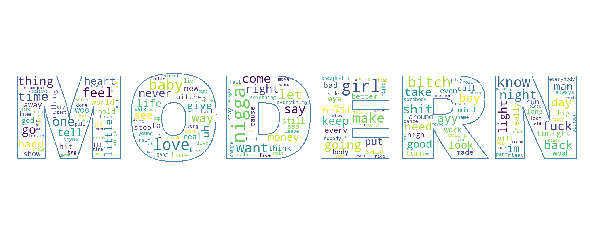

In [148]:
raw_lyrics = word_cloud_edition(compute_TF_IDF(all_lyrics_list))

mask1 = np.array(Image.open("mask1.png"))

wordcloud = WordCloud(width = 2000, height = 800, background_color ='white', min_font_size = 10, collocations=False, mask=mask1, contour_width=3, contour_color='steelblue').generate(raw_lyrics) 
wordcloud.to_file("wordcloud_all_modern.png")

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

> We gather the data from the second dataset, the one containing lyrics of 57650 pop songs of all eras. We run the same analysis on these new data.

In [132]:
pop_lyrics_list = []

with open('songdata.csv', newline='') as csvfile:
    filereader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in filereader:
        pop_lyrics_list.append(formatText(row[3].replace('\n',' ')))

In [146]:
pop_TF_IDF = compute_TF_IDF2(pop_lyrics_list)

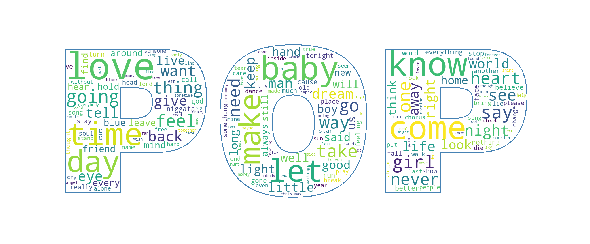

In [147]:
raw_pop_lyrics = word_cloud_edition(compute_TF_IDF(pop_lyrics_list))
mask1 = np.array(Image.open("mask2.png"))

wordcloud = WordCloud(width = 2000, height = 800, background_color ='white', min_font_size = 10, collocations=False, mask=mask1, contour_width=3, contour_color='steelblue').generate(raw_pop_lyrics) 
wordcloud.to_file("wordcloud_all_pop.png")

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#####  Analysis of verses

> To compute the most generic verses, we give an "genericness score" to every verse in our dataset. It corresponds to the sum of the TF-IDF scores of the verse's words, divided by the number of "meaningful words in the verse (thus after the stopwords are removed).

In [149]:
file = open('all_lyrics.txt','r')
all_verses_list = []
for lyrics in file.readlines():
    for verse in lyrics.replace('/n/n','/n').split('/n'):
        words = formatText(verse)
        score = 0
        for word in words:
            if word not in used_words:
                score += modern_TF_IDF[word]
                used_words.append(word)
                
        if len(used_words) > 5:
            all_verses_list.append((verse, score/len(used_words)))
        else:
            all_verses_list.append((verse, 0))

In [150]:
all_verses_list.sort(key=lambda x: -x[1])

> We get the following results, ordered from the most generic to the least generic verse:

In [151]:
all_verses_list

[("If you don't wanna see me", 0.0009918339625),
 ("Thinking 'bout the way I was", 0.00022627226666666666),
 ('If you wanna believe that anything could stop me', 0.00017963533214285715),
 ('Did a full 180, crazy', 0.00016830682000000001),
 ('Walk away, you know how', 0.00014550419142857142),
 ('Did the heartbreak change me? Maybe', 0.00014218279333333335),
 ("I'm all good already", 0.00013652435789473686),
 ("Don't show up, don't come out", 0.00010735145),
 ('But look at where I ended up', 0.00010689870588235294),
 ('Though it took some time to survive you', 9.260825454545453e-05),
 ("You take a sip 'fore we get gone", 8.835749852941176e-05),
 ("If you don't wanna see me dancing with somebody", 7.659780833333333e-05),
 ("This town ain't got no nightclub", 6.925611923076924e-05),
 ("We don't need the neon lights", 5.990026909090908e-05),
 ("I'm better on the other side", 5.766832608695652e-05),
 ('Got you a Bullet and koozie, keep it ice cold', 5.74383921875e-05),
 ('I hit a curb just t

> This is the list we used to create "the most generic song lyrics", by only looking at the first 65 verses of the list and extracting the ones that rhymed and made sense together.

#####  Sentiment analysis

> Using the labMT dataset to get the happiness score of a list of common words, we create a function that estimates the sentiment of the lyrics.

In [159]:
df = pd.read_csv('labMT.txt',index_col=0, delimiter = '\\t',engine='python')
wordlist = df.index.values.tolist()

#Function to estimate the sentiment of a list of tokens
def sentiment(tokens):
    sentiment_score, count = 0, 0
    
    #Considering tokens are standardized (in this case, lowercase)
    for word in tokens:
        if word in wordlist:
            count+=1
            sentiment_score += df.loc[word]['happiness_average']
    
    if count!=0:
        return(sentiment_score/count)
    else:
        return("Invalid")

> We then proceed to compute separately the sentiment of our modern hit songs, and the one of the "classic pop" songs.

In [172]:
modernSentiment = []
popSentiment = []

for song in all_lyrics_list:
    value = sentiment(song)
    if value != "Invalid":
        modernSentiment.append(value)
for song in pop_lyrics_list:
    value = sentiment(song)
    if value != "Invalid":
        popSentiment.append(value)

> We plot the distribution to visualize the results:

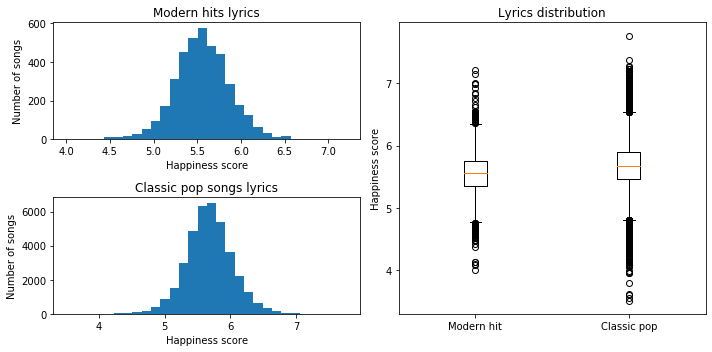

In [171]:
#Plot of the distribution of sentiments accross tweets for both parties
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.title('Modern hits lyrics')
hist, bins = np.histogram(modernSentiment,30) 
plt.hist(modernSentiment, bins) 
plt.ylabel("Number of songs")
plt.xlabel("Happiness score")

plt.subplot(223)
plt.title('Classic pop songs lyrics')
hist, bins = np.histogram(popSentiment,30) 
plt.hist(popSentiment, bins) 
plt.ylabel("Number of songs")
plt.xlabel("Happiness score")

plt.subplot(122)
plt.title('Lyrics distribution')
sentiments = [modernSentiment, popSentiment]
plt.boxplot(sentiments)
plt.xticks([1,2], ("Modern hit", "Classic pop"))
plt.ylabel("Happiness score")

plt.tight_layout()
plt.show()

> Modern hit songs are not very different from classic pop songs concerning sentiment, although they appear to be slightly “less happy” on average. We do observe as well that neither of our dataset include “very happy” or “very sad” songs.

# 4 - Discussion

### **What went well?**

In general, the project ran smoothly. We achieved what we wanted to do: *get a general idea of the structure of a popular song*. The previous notebook from this course were really helpful to quickly solve the main analysis, and the more project specific issues we could always quickly refer to internet or find an answer together. Also the different background of our groupmates led to an efficient workflow. From the website coding to the musical knowledge everyone had it's part in this project.

### **What is still missing? What could be improved? Why?**

Our main concern is that we couldn't completely create a song that summarizes our findings. Otherwise, there are other problems that occured in the project.
* First, the network that we choose was interesting but the database behind it (HookTheory) did not have enough data for us to finish our analysis.
* Second, we tried to get as much data as possible from de Billboard 100 chart but we quickly reached a state where our account could not request anymore data so we limited ourselves to 4000 songs dated from 2010.\
* Finally we didn't find a dataset describing songs' melody. So we are still missing this part to really achieve a complete song recipe.

# 5. Work distribution

<table style="width:100%; text-align:left;">
  <tr>
    <th style="text-align:left">Tanguy Navez</th>
    <th style="text-align:left">Erick Ah-Mouck</th>
    <th style="text-align:left">Gaëtan Moisson-Franckhauser</th>
  </tr>
  <tr>
    <td style="text-align:left">Website, data mining</td>
    <td style="text-align:left">Network analysis, data mining</td>
    <td style="text-align:left">Text analysis, data mining</td>
  </tr>
</table> 